In [1]:
import numpy as np
import sympy as sym
import pandas as pd
%matplotlib notebook
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import solve_ivp, solve_bvp, trapz

In [2]:
t = sym.symbols('t')
Q = sym.Matrix([[10,0],[0,1 + sym.Rational(1,8) * sym.sin(t)]])
R = sym.Matrix([1])
P1 = sym.Matrix([[100,0],[0,100]])

A = sym.Matrix([[0, 1+sym.Rational(1,2) * sym.sin(t)], [-1 - sym.Rational(1,2) * sym.cos(t), sym.Rational(1,4) * sym.sin(t)]])
B = sym.Matrix([0, 1 + sym.Rational(1,2) * sym.sin(t)])
#lambdify our time varying A and B
A_lam = sym.lambdify([t], A)
B_lam = sym.lambdify([t], B)

In [3]:
x0 = sym.Function('x_0')(t)
x1 = sym.Function('x_1')(t)

x = sym.Matrix([x0, x1])

x_fin = sym.MatrixSymbol('x(T)', 2, 1).as_explicit()
x_init = sym.Matrix([1,1]) 

u0 = sym.Function('u_0')(t)
u = sym.Matrix([u0])

p = sym.Matrix([sym.Function('p_0')(t), sym.Function('p_1')(t)])
p_fin = sym.MatrixSymbol('p_{1}', 2, 1).as_explicit()

In [4]:
x_d = sym.Matrix([0.1*t + 1, -0.2*t  + 1]) 
x_d_fin = x_d.subs(t,10)

In [5]:
P_0 = sym.Function("P_0")(t)
P_1 = sym.Function("P_1")(t)
P_2 = sym.Function("P_2")(t)
P_3 = sym.Function("P_3")(t)
P = sym.Matrix([[P_0, P_1],[P_2,P_3]])

Pdot = -P * A - A.T * P + P * B * R.inv() * B.T * P - Q
P_fin = P1

r0 = sym.Function("r_0")(t)
r1 = sym.Function("r_1")(t)
r = sym.Matrix([r0, r1])

rdot = -A.T * r + Q * x_d + P*B*R.inv()*B.T*r
r_fin = -P1 * x_d_fin

u = (-R.inv() * B.T * (P * x + r))
xdot = A * x + B * u

In [23]:
q_Pr = sym.Matrix([P.reshape(4,1), r])
q_Pr_dot = sym.Matrix([Pdot.reshape(4,1), rdot])
q_Pr_fin = sym.Matrix([P_fin.reshape(4,1), r_fin])

q_Pr_dot_lam = sym.lambdify([t, q_Pr], sym.flatten(q_Pr_dot))

In [81]:
#set up boundary condition
ans_Pr = solve_ivp(q_Pr_dot_lam, [10, 0], np.array(q_Pr_fin).flatten(), max_step = 0.0001)

In [82]:
ans_Pr.y.shape

(6, 100002)

In [83]:
P_t = np.flip(ans_Pr.y[:4,:].reshape(2,2,-1),2)
r_t = np.flip(ans_Pr.y[4:6,:].reshape(2,1,-1),2)
t_vec = np.flip(ans_Pr.t,-1)

In [84]:
P_t_init = P_t[:,:,0]
r_t_init = r_t[:,:,0]

In [85]:
q_xPr = sym.Matrix([P.reshape(4,1), r, x])
xdot = A*x + -B*R.inv()*B.T * (P * x + r)
xdot_lam = sym.lambdify([t, x, P, r], xdot)
q_xPr_dot = sym.Matrix([Pdot.reshape(4,1), rdot, xdot])
q_xPr_init = np.concatenate([P_t_init.reshape(4,1), r_t_init, np.array(x_init)]).flatten()
q_xPr_dot_lam = sym.lambdify([t, q_xPr], sym.flatten(q_xPr_dot))

In [86]:
ans_x = solve_ivp(q_xPr_dot_lam, (0,10), q_xPr_init, t_eval=t_vec)
ans_x

  message: 'Required step size is less than spacing between numbers.'
     nfev: 680
     njev: 0
      nlu: 0
      sol: None
   status: -1
  success: False
        t: array([0.00000000e+00, 4.13898733e-06, 1.04138987e-04, ...,
       2.84330414e+00, 2.84340414e+00, 2.84350414e+00])
 t_events: None
        y: array([[ 6.63112085e+00,  6.63111264e+00,  6.63091427e+00, ...,
         2.13103026e+04,  4.15262718e+04,  7.25440153e+05],
       [ 1.70409117e+00,  1.70409043e+00,  1.70407263e+00, ...,
         8.85665740e+03,  1.72554108e+04,  3.01388368e+05],
       [ 1.70409117e+00,  1.70409043e+00,  1.70407263e+00, ...,
         8.85665740e+03,  1.72554108e+04,  3.01388368e+05],
       ...,
       [-2.89830758e+00, -2.89830460e+00, -2.89823238e+00, ...,
        -1.00709248e+04, -1.96207381e+04, -3.42694480e+05],
       [ 1.00000000e+00,  1.00000414e+00,  1.00010413e+00, ...,
         1.12370933e+00,  1.12371301e+00,  1.12371669e+00],
       [ 1.00000000e+00,  9.99990398e-01,  9.99758422e-0

In [56]:
# xdot_lam(0, x_init, sym.flatten(P_t_init), sym.flatten(r_t_init))
# xdot(1, x_init)
# np.where(t_vec == t_vec[2])[0][0]

In [57]:
i = 0
def xdot(t, x):
    global i
    P = P_t[:,:,i]
    r = r_t[:,:,i]
    i+=1
    x_ret = xdot_lam(t, x, P.flatten(), r.flatten())
    return x_ret.flatten()
    

In [58]:
ans_x = solve_ivp(xdot, (0,10), np.array(x_init).flatten(), t_eval=t_vec)





In [74]:
x_t = ans_x.y[:2, ].reshape(2,1,-1)

In [59]:
ans_x.y.shape

(2, 1004)

In [76]:
x_d_traj = sym.lambdify([t], x_d)
x_d_traj = x_d_traj(ans_x.t)

<IPython.core.display.Javascript object>


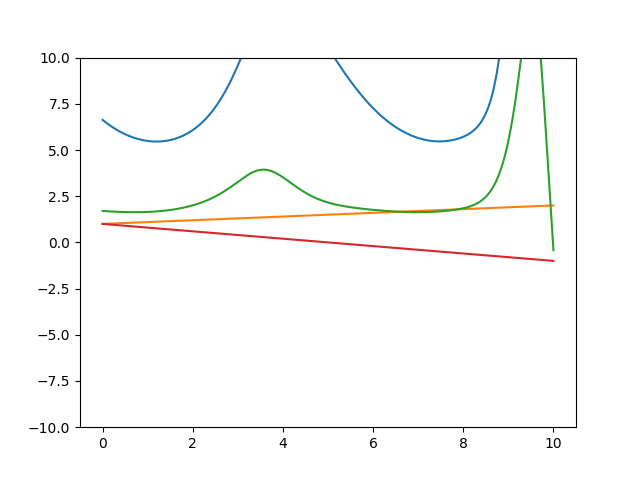

In [79]:
plt.figure()
plt.plot(t_vec, x_t[0,0,:])
plt.plot(t_vec, x_d_traj[0,0,:])
plt.plot(t_vec, x_t[1,0,:])
plt.plot(t_vec, x_d_traj[1,0,:])
plt.ylim([-10,10])
plt.show()